In [81]:
import torch
import matplotlib.pyplot as plt
import numpy as np

from src.train import train
from src.datas import transforms
from src.datas.dataloader import get_dataloader
from src.models import mae_vit_regressor

# CaCO3

In [82]:
target_task = "CaCO3"
annotation_file = f"data/finetune/{target_task}%/train/info.csv"
input_dir = f"data/finetune/{target_task}%/train/"

target_mean = f"src/datas/xpt_{target_task}_target_mean.pth"
target_std = f"src/datas/xpt_{target_task}_target_std.pth"

pretrained_weight = f"results/pretrain-mask-ratio-0.7-blr-1e-4-transform-instance_normalize/{target_task}/model.ckpt"

device = "cuda"

In [83]:
target_mean = torch.load(target_mean)
target_std = torch.load(target_std)
target_transform = transforms.Normalize(target_mean, target_std)

dataloader = get_dataloader(
    ispretrain=False,
    annotations_file=annotation_file,
    input_dir=input_dir,
    batch_size=56,
    transform=transforms.InstanceNorm(),
    target_transform=target_transform,
    num_workers=1,
    pin_memory=True,
)

In [84]:
model = mae_vit_regressor.mae_vit_base_patch16(pretrained=True,
                                               weights=pretrained_weight)
criterion = torch.nn.MSELoss()

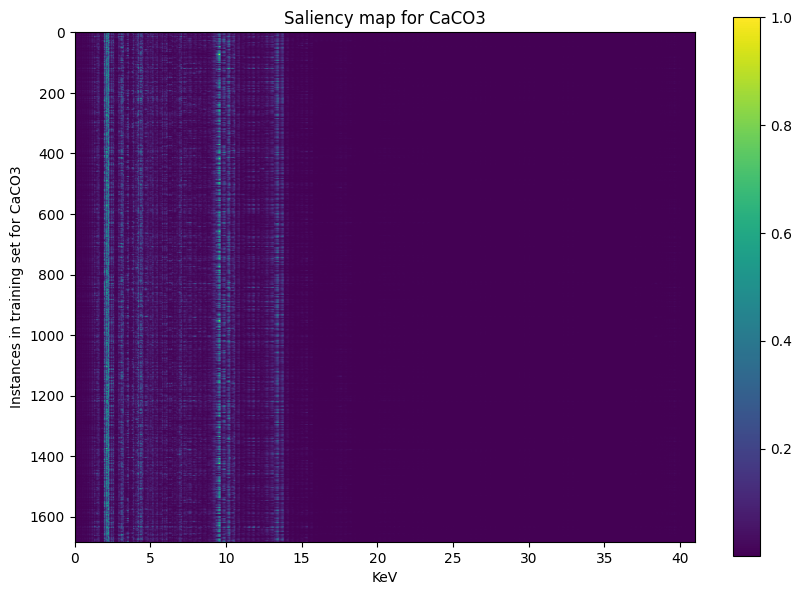

In [85]:
model.eval()
model = model.cuda()

total_saliency_map = torch.empty([0, 2048])
for batch in dataloader["train"]:
    samples = batch["spe"].to(device, non_blocking=True, dtype=torch.float)
    samples.requires_grad = True
    targets = batch["target"].to(device, non_blocking=True, dtype=torch.float)

    preds = model(samples)
    loss = criterion(preds, targets)
    loss.backward()

    saliency_map = samples.grad.data.abs()
    saliency_map /= saliency_map.max(dim=-1)[0].unsqueeze(dim=-1)
    total_saliency_map = torch.concat([total_saliency_map, saliency_map.cpu()], dim=0)

# transform channel to KeV
xticks = np.arange(0, 2048, 250)
xlabels = (xticks*0.02).astype(int)

fig, ax = plt.subplots(figsize=(10, 7))
ax.set_xlabel("KeV")
ax.set_ylabel(f"Instances in training set for {target_task}")
ax.set_title(f"Saliency map for {target_task}")
ax.set_xticks(xticks)
ax.set_xticklabels(xlabels)
cax = ax.imshow(total_saliency_map.cpu().numpy())
cbar = fig.colorbar(cax, ax=ax, orientation='vertical')
plt.show()

In [86]:
caco3_sa = saliency_map.cpu().numpy()

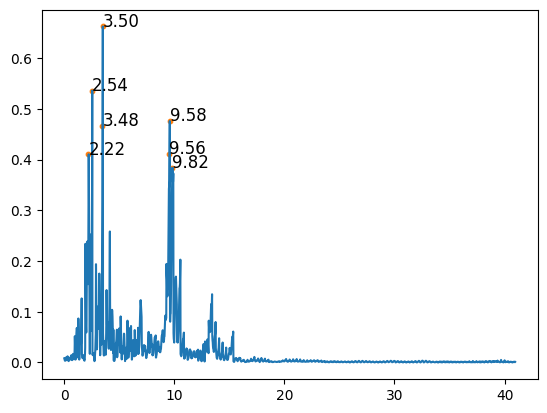

In [87]:
rank = 7

sa_array = caco3_sa.mean(axis=0)
rank_idx = sa_array.argsort()[-rank:]
sa_sort = sa_array[rank_idx]

plt.plot(np.linspace(1, 2048, 2048) * 0.02, sa_array)
plt.scatter(rank_idx * 0.02, sa_sort, c='C1', s=10)

for idx in rank_idx:
    plt.text(idx * 0.02, sa_array[idx], f"{idx*0.02:.2f}", fontsize=12)

In [88]:
rank_idx = sa_array.argsort()[-80:]
rank_idx * 0.02

array([ 3.16,  6.94,  9.68,  1.58,  1.96, 10.2 , 10.44,  9.36,  9.38,
       13.42,  9.34, 10.08, 10.18,  3.84,  9.42, 10.46, 10.48,  2.9 ,
        3.2 ,  9.4 ,  2.04,  2.16, 10.5 ,  9.7 , 10.16,  3.42, 10.1 ,
        9.32, 10.12, 10.14,  2.28,  9.3 ,  2.44, 10.52,  4.12,  3.18,
        2.36,  1.94,  2.88,  9.28,  2.14,  9.44,  2.06, 10.54,  9.72,
        2.18,  3.44,  2.12,  2.08,  9.74,  2.42,  1.92,  2.1 ,  2.38,
        2.4 ,  9.46,  4.14,  2.26,  9.76,  2.52,  9.48,  2.2 ,  3.46,
        9.78,  9.5 ,  9.52,  2.24,  9.86,  9.88,  9.54,  9.8 ,  9.84,
        9.9 ,  9.82,  2.22,  9.56,  3.48,  9.58,  2.54,  3.5 ])

The peaks locate around 2.2-2.6, 3.4-3.6, 9.5-10.5, 13.4-13.45.

Text(3.69, 0.6, '3.69')

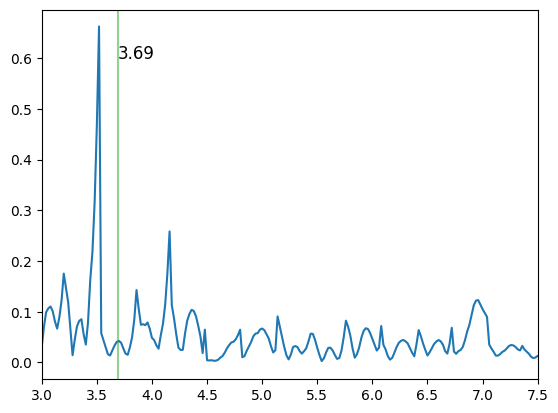

In [89]:
# does Ca peaks (ka1=3.691, ka2=3.688) have the highest saliency?
rank = 7

sa_array = caco3_sa.mean(axis=0)
plt.plot(np.linspace(1, 2048, 2048) * 0.02, sa_array)

plt.xlim(3, 7.5)
ev = 3.69
plt.axvline(ev, c="C2", alpha=0.5)
plt.text(ev, 0.6, str(ev), fontsize=12)

Hmm... The model does not take Ca signal as the main factor.

# TOC

In [90]:
target_task = "TOC"
annotation_file = f"data/finetune/{target_task}%/train/info.csv"
input_dir = f"data/finetune/{target_task}%/train/"

target_mean = f"src/datas/xpt_{target_task}_target_mean.pth"
target_std = f"src/datas/xpt_{target_task}_target_std.pth"

pretrained_weight = f"results/pretrain-mask-ratio-0.7-blr-1e-4-transform-instance_normalize/{target_task}/model.ckpt"

device = "cuda"

In [91]:
target_mean = torch.load(target_mean)
target_std = torch.load(target_std)
target_transform = transforms.Normalize(target_mean, target_std)

dataloader = get_dataloader(
    ispretrain=False,
    annotations_file=annotation_file,
    input_dir=input_dir,
    batch_size=56,
    transform=transforms.InstanceNorm(),
    target_transform=target_transform,
    num_workers=1,
    pin_memory=True,
)

In [92]:
model = mae_vit_regressor.mae_vit_base_patch16(pretrained=True,
                                               weights=pretrained_weight)
criterion = torch.nn.MSELoss()

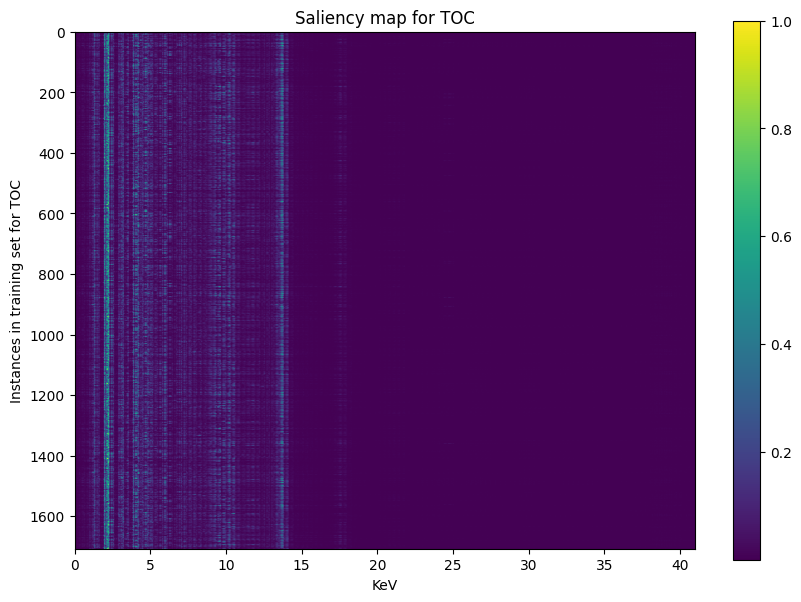

In [93]:
model.eval()
model = model.cuda()

total_saliency_map = torch.empty([0, 2048])
for batch in dataloader["train"]:
    samples = batch["spe"].to(device, non_blocking=True, dtype=torch.float)
    samples.requires_grad = True
    targets = batch["target"].to(device, non_blocking=True, dtype=torch.float)

    preds = model(samples)
    loss = criterion(preds, targets)
    loss.backward()

    saliency_map = samples.grad.data.abs()
    saliency_map /= saliency_map.max(dim=-1)[0].unsqueeze(dim=-1)
    total_saliency_map = torch.concat([total_saliency_map, saliency_map.cpu()], dim=0)

xticks = np.arange(0, 2048, 250)
xlabels = (xticks*0.02).astype(int)

fig, ax = plt.subplots(figsize=(10, 7))
ax.set_xlabel("KeV")
ax.set_ylabel(f"Instances in training set for {target_task}")
ax.set_title(f"Saliency map for {target_task}")
ax.set_xticks(xticks)
ax.set_xticklabels(xlabels)
cax = ax.imshow(total_saliency_map.cpu().numpy())
cbar = fig.colorbar(cax, ax=ax, orientation='vertical')
plt.show()

In [94]:
toc_sa = saliency_map.cpu().numpy()

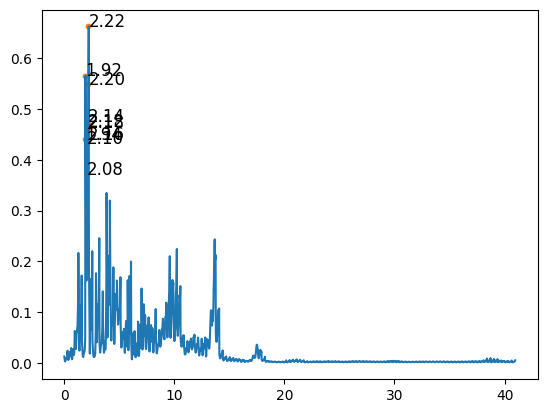

In [95]:
rank = 10
sa_array = toc_sa.mean(axis=0)
rank_idx = sa_array.argsort()[-rank:]
sa_sort = sa_array[rank_idx]

plt.plot(np.linspace(1, 2048, 2048) * 0.02, sa_array)
plt.scatter(rank_idx * 0.02, sa_sort, c='C1', s=10)

for idx in rank_idx:
    plt.text(idx * 0.02, sa_array[idx], f"{idx*0.02:.2f}", fontsize=12)

Text(17.5, 0.04, '17.5')

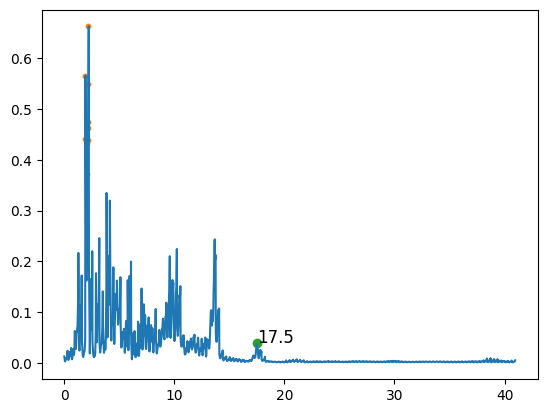

In [96]:
plt.plot(np.linspace(1, 2048, 2048) * 0.02, sa_array)
plt.scatter(rank_idx * 0.02, sa_sort, c='C1', s=10)

ev = 17.5
plt.scatter(ev, 0.04, c="C2")
plt.text(ev, 0.04, str(ev), fontsize=12)

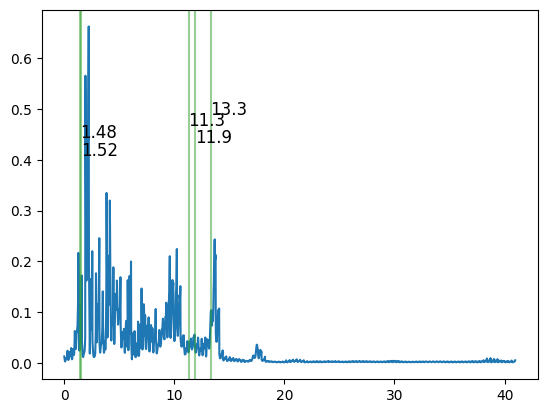

In [131]:
# does Br peaks have the highest saliency?
rank = 7

sa_array = toc_sa.mean(axis=0)
plt.plot(np.linspace(1, 2048, 2048) * 0.02, sa_array)

#plt.xlim(10, 7.5)
evs = [11.9, 11.3, 13.3, 1.48, 1.52]
for ev in evs: 
    plt.axvline(ev, c="C2", alpha=0.5)
    plt.text(ev, 0.4+np.random.rand(1)/8, str(ev), fontsize=12)

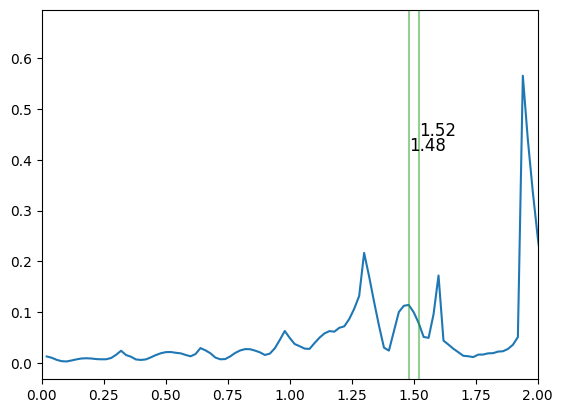

In [132]:
# does Br peaks have the highest saliency?
rank = 7

sa_array = toc_sa.mean(axis=0)
plt.plot(np.linspace(1, 2048, 2048) * 0.02, sa_array)

plt.xlim(0, 2)
evs = [1.48, 1.52]
for ev in evs: 
    plt.axvline(ev, c="C2", alpha=0.5)
    plt.text(ev, 0.4+np.random.rand(1)/8, str(ev), fontsize=12)

The peaks locate more broadly within 2 to 10 compared to CaCO3. Also it has a small peak at around 17.5. It indeed takes Br signals (1.48 & 1.52) into account but still not main factors.

In [133]:
rank_idx = sa_array.argsort()[-500:-300]
rank_idx * 0.02

array([11.86,  8.74,  2.58,  3.32, 10.62, 13.06,  3.7 ,  7.7 , 12.04,
        8.5 , 11.16, 17.46,  8.7 ,  6.82,  7.46, 10.68,  3.76, 12.64,
        5.22,  8.52,  3.34, 13.12,  8.56, 13.04,  1.88, 17.48, 17.5 ,
        6.54,  3.36,  1.62,  8.58,  8.76, 12.1 ,  8.54, 11.52,  7.78,
       12.08, 12.06, 13.08, 12.5 , 12.7 , 11.68,  4.54,  1.  , 12.66,
        8.78, 11.38, 12.94,  3.38,  6.56, 12.68,  3.56,  8.14,  6.58,
       12.82, 12.18, 12.78,  1.08, 13.2 , 11.46,  3.2 ,  6.08,  7.38,
       10.6 ,  2.84, 10.72,  3.68, 11.84,  5.46,  6.98, 11.4 ,  2.96,
       13.02, 11.44, 12.12,  2.3 ,  6.3 ,  8.04, 13.82,  8.68,  8.16,
       12.46,  2.56,  5.16, 11.48,  5.54,  8.18,  6.2 ,  7.96,  8.2 ,
        6.42, 10.58, 11.42,  3.66,  6.68, 11.18,  8.34, 10.  ,  7.68,
       13.84,  3.4 , 12.96, 11.7 ,  8.66,  1.6 ,  4.28, 13.1 ,  6.94,
       13.  ,  5.7 ,  4.26,  7.08,  0.94,  5.24, 10.02,  8.6 ,  8.8 ,
       10.74,  9.1 , 12.98, 13.86,  5.84,  7.98, 13.8 ,  7.48,  9.98,
       12.48,  7.94,

I think I need to find another way to visualize. Perhaps take one instance and plot the spectrum together with the gradient.

Useful links:
https://xdb.lbl.gov/Section1/Periodic_Table/X-ray_Elements.html